In [1]:
import os, sys
import pickle
from pathlib import Path
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'  # https://stackoverflow.com/questions/65907365/tensorflow-not-creating-xla-devices-tf-xla-enable-xla-devices-not-set
import logging
logger = logging.getLogger(__name__)
logger.level = logging.INFO
logging.getLogger().level = logging.INFO
logging.getLogger().handlers = [logging.StreamHandler(sys.stdout)]

import pandas as pd 
from scipy.spatial import cKDTree
import importlib.util
def module_from_file(module_name, file_path): #The code that imports the file which originated the training with all the instructions
            spec = importlib.util.spec_from_file_location(module_name, file_path)
            module = importlib.util.module_from_spec(spec)
            spec.loader.exec_module(module)
            return module

from importlib import import_module
#foo = import_module(fold_folder+'/Funs.py', package=None)


#folder = './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.1.20lrs4'
folder = './xforanalogs/NH24by128/Z16/yrs500/interT15fw20.1.20kl.99.1c1..1skip2/'
foo = module_from_file("foo", f'{folder}/Funs.py')
ef = foo.ef # Inherit ERA_Fields_New from the file we are calling
ut = foo.ut

Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


2022-07-13 15:29:32.998671: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


path_to_ERA = '/ClimateDynamics/MediumSpace/ClimateLearningFR/gmiloshe'/ERA/
Trying to import basemap
In this environment you cannot import Basemap
Trying to import cartopy
Trying to import basemap
In this environment you cannot import Basemap
Trying to import cartopy
Successfully imported cartopy
Successfully imported cartopy
==Checking GPU==
From ./xforanalogs/NH24by128/Z16/yrs500/interT15fw20.1.20kl.99.1c1..1skip2//Funs.py:46: is_gpu_available (from tensorflow.python.framework.test_util) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
==Checking CUDA==


2022-07-13 15:29:37.405803: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-13 15:29:37.470190: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2299955000 Hz
2022-07-13 15:29:37.475967: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55c8826fa030 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-07-13 15:29:37.476015: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-07-13 15:29:37.479578: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-07-13 15:29:37.947718: I tensorflow/core/common_runtime/

In [2]:
import random as rd  
from scipy.stats import norm
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.metrics import log_loss

tff = foo.tff # tensorflow routines 
ut = foo.ut # utilities
ln = foo.ln #Learn2_new.py
print("==Checking GPU==")
import tensorflow as tf
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

print("==Checking CUDA==")
tf.test.is_built_with_cuda()

#from tensorflow.keras.preprocessing.image import ImageDataGenerator
sys.path.insert(1, '../ERA')

print("==Reading data==")

year_permutation = np.load(f'{folder}/year_permutation.npy')

==Checking GPU==
==Checking CUDA==
==Reading data==


2022-07-13 15:29:39.195932: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-07-13 15:29:39.196904: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:82:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-07-13 15:29:39.196980: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-07-13 15:29:39.197044: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-07-13 15:29:39.197119: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic libr

In [3]:
checkpoints = [10,100,1000]
run_vae_kwargs = ut.json2dict(f"{folder}/config.json")
T = ut.extract_nested(run_vae_kwargs, 'T')
if (ut.keys_exists(run_vae_kwargs, 'label_period_start') and ut.keys_exists(run_vae_kwargs, 'label_period_end')):
    label_period_start = ut.extract_nested(run_vae_kwargs, 'label_period_start')
    label_period_end = ut.extract_nested(run_vae_kwargs, 'label_period_end')
    time_start = ut.extract_nested(run_vae_kwargs, 'time_start')
    time_end = ut.extract_nested(run_vae_kwargs, 'time_end')
    #if label_period_start is not None:
    #    time_start = label_period_start
    #if label_period_end is not None:
    #    time_end = label_period_end
    run_vae_kwargs = ut.set_values_recursive(run_vae_kwargs, {'myinput' : 'N', 'evaluate_epoch' :checkpoints[-1], 'time_start' : time_start})#, 'time_end' : time_end})
else:
    run_vae_kwargs = ut.set_values_recursive(run_vae_kwargs, {'myinput' : 'N', 'evaluate_epoch' :checkpoints[-1]}) # backward compatibiity where there was no month of may
if not os.path.exists(ut.extract_nested(run_vae_kwargs, 'mylocal')): # we are assuming that training was not run on R740server5
    run_vae_kwargs = ut.set_values_recursive(run_vae_kwargs, {'mylocal' : '/ClimateDynamics/MediumSpace/ClimateLearningFR/gmiloshe/PLASIM/'})

In [4]:
fold = 0
run_vae_kwargs = ut.set_values_recursive(run_vae_kwargs, {'range_nfolds' : [fold]})
history, N_EPOCHS, INITIAL_EPOCH, checkpoint_path, LAT, LON, vae, X_va, Y_va, X_tr, Y_tr, analogues = foo.run_vae(folder, **run_vae_kwargs)
import pickle
open_file = open(f'{folder}/fold_{fold}/analogues.pkl', "rb")
analogues = pickle.load(open_file)
open_file.close()

X = np.concatenate((X_va, X_tr),axis=0)
X.shape

run_vae:
    myinput = 'N'
     inputs lat_W = 24, lon_W = 128
    encoder_conv_filters1 = 16, encoder_conv_kernel_size1 = 5, encoder_conv_strides1 = 2, encoder_conv_padding1 = 'same'
     processing layer results in the dimension lat_W = 12.0, lon_W = 64.0
    encoder_conv_filters1 = 16, encoder_conv_kernel_size1 = 5, encoder_conv_strides1 = 1, encoder_conv_padding1 = 'same'
     processing layer results in the dimension lat_W = 12.0, lon_W = 64.0
    encoder_conv_filters1 = 16, encoder_conv_kernel_size1 = 5, encoder_conv_strides1 = 1, encoder_conv_padding1 = 'same'
     processing layer results in the dimension lat_W = 12.0, lon_W = 64.0
    encoder_conv_filters1 = 32, encoder_conv_kernel_size1 = 5, encoder_conv_strides1 = 2, encoder_conv_padding1 = 'same'
     processing layer results in the dimension lat_W = 6.0, lon_W = 32.0
    encoder_conv_filters1 = 32, encoder_conv_kernel_size1 = 5, encoder_conv_strides1 = 1, encoder_conv_padding1 = 'same'
     processing layer results in the 

2022-07-13 15:32:02.760859: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-07-13 15:32:02.761789: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:82:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-07-13 15:32:02.761852: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-07-13 15:32:02.761923: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-07-13 15:32:02.761969: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic libr

            shape_before_flattening =                          (1, 14, 64)            
            AutoGraph could not transform <bound method Sampling.call of <ERA.TF_Fields.Sampling object at 0x14c6b4151ca0>> and will run it as-is.
            Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
            Cause: module 'gast' has no attribute 'Index'
            To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
            Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
            Cause: module 'gast' has no attribute 'Index'
            To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert            
            Model: "encoder"            
            _____________________________

2022-07-13 15:32:05.363683: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-07-13 15:32:05.643982: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-07-13 15:32:05.932279: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


        Evaluating classification
        vae.classifier fit
        Y_pr_prob_va = vae.classifier.predict(z_va)
        Y_pr_prob_tr = vae.classifier.predict(z_tr)
        Y_tr.shape = (47250,), Y_pr_prob_tr.shape = (47250,) 
        vaebce_va = <tf.Tensor: shape=(), dtype=float32, numpy=4.2649584>, vaebce_tr = <tf.Tensor: shape=(), dtype=float32, numpy=4.1920743> 
        checkpoint_path = 'xforanalogs/NH24by128/Z16/yrs500/interT15fw20.1.20kl.99.1c1..1skip2/fold_0/cp_vae-1000.ckpt'
        ==loading the model: xforanalogs/NH24by128/Z16/yrs500/interT15fw20.1.20kl.99.1c1..1skip2/fold_0/cp_vae-1000.ckpt
        xforanalogs/NH24by128/Z16/yrs500/interT15fw20.1.20kl.99.1c1..1skip2/fold_0/cp_vae-1000.ckpt weights loaded
        classify:
        classify: completed in 0.0 s
        RAM memory: 1.126e+11
         fold to terminate with repeat_nan_local = -1
    k_fold_cross_val: completed in 17.7 s
run_vae: completed in 2 min 6.3 s


(52500, 24, 128, 3)

In [5]:
fold = 0
fold_folder = f'{folder}/fold_{fold}'
checkpoint = 10
nb_zeros_c = 4-len(str(checkpoint))
checkpoint_i = '/cp_vae-'+nb_zeros_c*'0'+str(checkpoint)+'.ckpt' # TODO: convert to f-strings
vae.load_weights(f'{fold_folder}/{checkpoint_i}')

#example_images = X_va[day_permutation] # random sample of 5 images from X's 0 axis


_,_,z = vae.encoder.predict(X[:1,...])

reconst_images.shape = (5, 24, 128, 3)
images0.shape = (5, 24, 128)
levels = array([0.        , 0.01587302, 0.03174603, 0.04761905, 0.06349206,
       0.07936508, 0.0952381 , 0.11111111, 0.12698413, 0.14285714,
       0.15873016, 0.17460317, 0.19047619, 0.20634921, 0.22222222,
       0.23809524, 0.25396825, 0.26984127, 0.28571429, 0.3015873 ,
       0.31746032, 0.33333333, 0.34920635, 0.36507937, 0.38095238,
       0.3968254 , 0.41269841, 0.42857143, 0.44444444, 0.46031746,
       0.47619048, 0.49206349, 0.50793651, 0.52380952, 0.53968254,
       0.55555556, 0.57142857, 0.58730159, 0.6031746 , 0.61904762,
       0.63492063, 0.65079365, 0.66666667, 0.68253968, 0.6984127 ,
       0.71428571, 0.73015873, 0.74603175, 0.76190476, 0.77777778,
       0.79365079, 0.80952381, 0.82539683, 0.84126984, 0.85714286,
       0.87301587, 0.88888889, 0.9047619 , 0.92063492, 0.93650794,
       0.95238095, 0.96825397, 0.98412698, 1.        ])
jterate =  0
iterate = 0, jterate = 0,img0.shape = (24, 128),im

/tmp/ipykernel_1001823/3260124005.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig2.tight_layout()


 saved to Images/project_reconstruct10.png


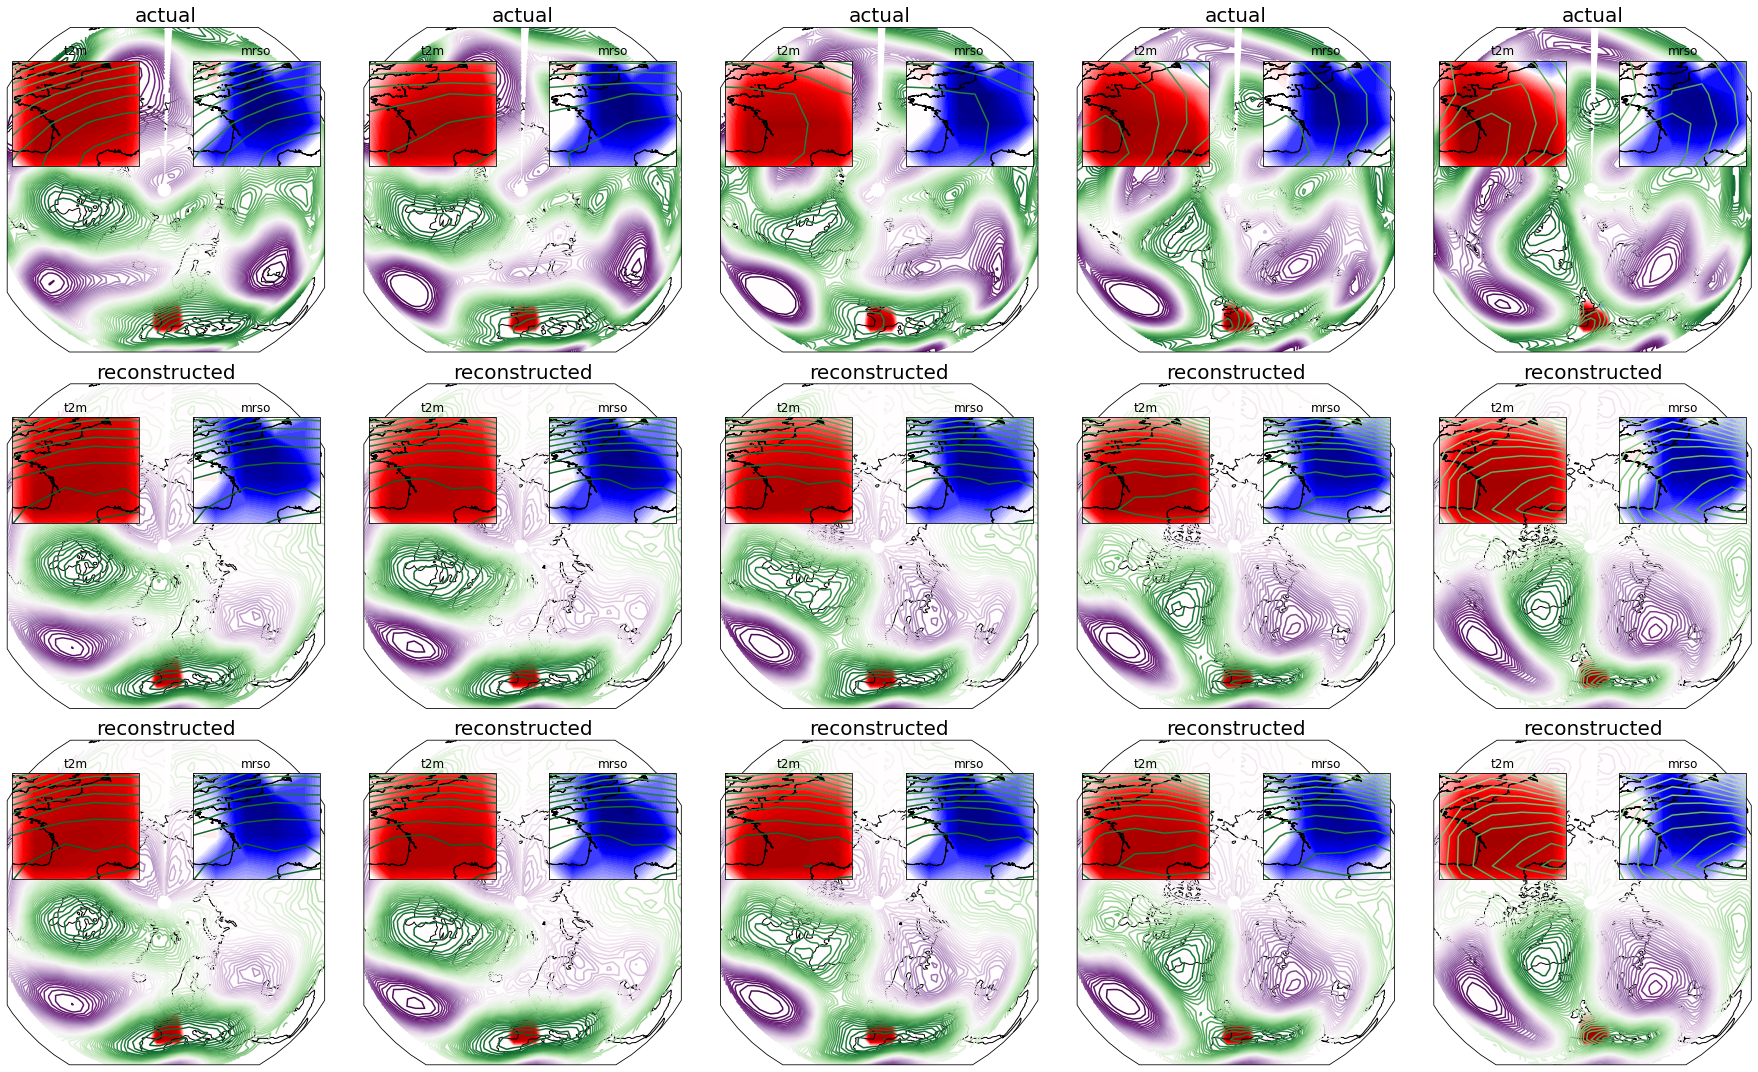

In [13]:
logger = logging.getLogger(__name__)
logger.level = logging.INFO

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.mpl.geoaxes

import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeat
data_proj = ccrs.PlateCarree()
sys.path.insert(1, '../ERA')
import cartopy_plots as cplt


example_images = X_va[:5]

def plot_compare(model, images=None): 
    # Plot images as well as their reconstruction
    model.encoder(images)
    mean, logvar, z_sample = model.encoder(images)
    reconst_images = model.decoder(z_sample).numpy()
    
    reconst_images2 = reconst_images[...,2] # remove extra fields 
    reconst_images1 = reconst_images[...,1] # remove extra fields 
    reconst_images0 = reconst_images[...,0] # remove extra fields 
    logger.info(f"{reconst_images.shape = }")
    images2 = images[...,2]
    images1 = images[...,1]
    images0 = images[...,0]
    logger.info(f"{images0.shape = }")
    
    n_to_show = 3*images0.shape[0]
    
    levels = np.linspace(0, 1, 64)
    logger.info(f"{levels = }")
    fig2 = plt.figure(figsize=(25, 15))
    spec2 = gridspec.GridSpec(ncols=5, nrows=3, figure=fig2)
    iterate = 0
    jterate = 0
    ax = []
    axins = []
    for i in range(n_to_show):
        print("jterate = ", jterate)
        m = fig2.add_subplot(spec2[jterate,iterate], projection=ccrs.Orthographic(central_latitude=90))
        ax.append(m)
        if jterate == 0:
            img2 = images2[i].squeeze()
            img1 = images1[i].squeeze() 
            img0 = images0[i].squeeze() 
        elif jterate == 1:
            img2 = reconst_images2[i-5].squeeze() 
            img1 = reconst_images1[i-5].squeeze()  
            img0 = reconst_images0[i-5].squeeze()  
        else:
            img2 = reconst_images2[i-10].squeeze() 
            img1 = reconst_images1[i-10].squeeze()  
            img0 = reconst_images0[i-10].squeeze() 
        logger.info(f"{iterate = }, {jterate = },{img0.shape = },{img0.min() = }, {img0.max() = }")
        m.set_extent([-180,180, 30, 90], crs=data_proj)
        
        logger.info(f"{LON.shape = } ,{LAT.shape = } ,{img0.shape = }, {img1.shape = }")
        if jterate == 0:
            ef.geo_contourf(m, ax[iterate], 0, LON, LAT,img0,levels, "seismic", f"actual", put_colorbar=False, draw_gridlines=False)
            ef.geo_contour (m, ax[iterate], 0, LON, LAT,img1,levels, "summer", "PRGn")
        elif jterate == 1:
            ef.geo_contourf(m, ax[iterate], 0, LON, LAT,img0,levels, "seismic", f"reconstructed", put_colorbar=False, draw_gridlines=False)
            ef.geo_contour (m, ax[iterate], 0, LON, LAT,img1,levels, "summer", "PRGn")
        else:
            ef.geo_contourf(m, ax[iterate], 0, LON, LAT,img0,levels, "seismic", f"reconstructed", put_colorbar=False, draw_gridlines=False)
            ef.geo_contour (m, ax[iterate], 0, LON, LAT,img1,levels, "summer", "PRGn")
            
        for img_sub, loc_string, title_sub in zip([img0, img2],["upper left","upper right"],["t2m","mrso"]):
            axins.append(inset_axes(m, width="40%", height="50%", loc=loc_string, 
                       axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                       axes_kwargs=dict(map_projection=cartopy.crs.PlateCarree())))


            axins[-1].add_feature(cartopy.feature.COASTLINE)
            axins[-1].set_extent([-5,7, 42, 52], crs=data_proj)

            ef.geo_contourf(axins[-1], ax[iterate], 0, LON, LAT,img_sub,levels, "seismic", "", put_colorbar=False, draw_gridlines=False)
            ef.geo_contour (axins[-1], ax[iterate], 0, LON, LAT,img1,levels, "summer", "PRGn")


            axins[-1].set_title(title_sub)
            
            
        iterate += 1
        if iterate > 4:
            iterate = 0
            jterate = jterate+1
    fig2.tight_layout()
    fig2.savefig(f"Images/project_reconstruct{checkpoint}.png", bbox_inches='tight', dpi=200)
    logger.info(f" saved to Images/project_reconstruct{checkpoint}.png")
plot_compare(vae,example_images)